In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import numpy as np

# Prevents crashes when showing graphs
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
SIM_STEPS = 201

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
# Pre-Determined train/test/val split
train_sims = np.load("../train_sims.npy")
train_sims = train_sims[train_sims < 750]
val_sims = np.load("../val_sims.npy")
val_sims = val_sims[val_sims < 750]
test_sims = np.load("../test_sims.npy")
test_sims = test_sims[test_sims < 750]

# Get porosity phi
def get_phi(sim,step):
    return cv2.imread(f"../Data200x200_withinfo/Image-{sim}-{step}_phi.jpg", cv2.IMREAD_GRAYSCALE)

# Get pressure
def get_pres(sim,step):
    return cv2.imread(f"../Data200x200_withinfo/Image-{sim}-{step}_P.jpg", cv2.IMREAD_GRAYSCALE)

# Get conductivity K
def get_k(sim,step):
    return cv2.imread(f"../Data200x200_withinfo/Image-{sim}-{step}_K.jpg", cv2.IMREAD_GRAYSCALE)

# Get all 3 as a 3-channel matrix
def get_all(sim,step):
    return np.array((get_k(sim,step), get_pres(sim,step), get_phi(sim,step)), dtype=np.float32)

In [3]:
# Darcy loss function
def darcy_loss(model, inp):
    # Takes in the k,pres,phi and outputs the prediction across the image.
    inp = inp.requires_grad_(True)
    out = model(inp)
    # out is in order K,P,phi, (conductivity, pressure, porosity)

    # Impose high pressure along the entire upper line by setting the pressure channelt to 200.
    out[:, 1:2, 0, :] = 200

    # If we assume the output is in order k,pres,phi
    # pres_grad is the gradient of the pressure along the y and x directions as a tuple
    pres_grad = torch.gradient(out[:, 1:2], dim=(-2,-1))

    # get velocity by multiplying the gradient by the conductivity
    y_grad = pres_grad[0] * out[:, 0:1]
    x_grad = pres_grad[1] * out[:, 0:1]

    # compute the divergence by the second derivative of the gradients and adding them together
    yy_grad = torch.gradient(y_grad, spacing=(1,),dim=(-2,))[0]
    xx_grad = torch.gradient(x_grad, spacing=(1,),dim=(-1,))[0]
    final = yy_grad + xx_grad

    # total divergence should be 0
    loss = (final**2).mean()

    return loss, out

In [4]:
# Building Blocks of the Unet

class TwoConv(nn.Module):
    # Basic block with 2 convolutional layers, each with a batch norm and relu
    
    def __init__(self, in_channels, out_channels, no_end_relu=False):
        super().__init__()
        
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        if no_end_relu:
            self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            )

    def forward(self, inp):
        return self.seq(inp)

# A single conv layer that will increase the height and width of the matrix by 2 each.
class SmallUp(nn.Module):

    def __init__(self, channels):
        super().__init__()

        self.conv = nn.Conv2d(channels, channels, 3, 1, 2)

    def forward(self, inp):
        return F.relu(self.conv(inp))

# A single conv layer that will decrease the height and width of the matrix by 2 each.
class SmallDown(nn.Module):

    def __init__(self, channels):
        super().__init__()

        self.conv = nn.Conv2d(channels, channels, 3, 1, 0)

    def forward(self, inp):
        return F.relu(self.conv(inp))
    
# Applies two convolutional layers, then pools
class Downsample(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv = TwoConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, inp):

        return self.pool(self.conv(inp))

# Upsamples and concatenates the upsampled matrix with the "across" then performs convolution on the result
class Upsample(nn.Module):

    def __init__(self, in_channels, out_channels, tweak=None):
        super().__init__()
        # Upsamples by 2x
        self.up = nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1)
        self.tweak = tweak
        self.conv_after = TwoConv(in_channels, out_channels)

    def forward(self, below, across):
        # First upsample by 2x
        upsampled = self.up(below)
        # If tweak is active, apply it first
        if not self.tweak == None:
            upsampled = self.tweak(upsampled)
        # Concatenate with the same size on the downswing of the unet
        concat = torch.concat((upsampled, across), dim=-3)
        # Convolute them together
        return self.conv_after(concat)
    
# Define the actual model used
class SmallUnet(nn.Module):
    
    def __init__(self):
        super().__init__()

        # Input is Nx3x200x200
        self.c1 = TwoConv(3, 8)
        self.d1 = Downsample(8,16) # 16x100x100
        self.d2 = Downsample(16,32) # 32x50x50
        self.su = nn.Sequential(
            SmallUp(32),
            SmallUp(32),
            SmallUp(32)
        ) # 3x56x56
        self.d3 = Downsample(32,64) # 64x28x28
        self.d4 = Downsample(64,128) # 128x14x14
        self.d5 = Downsample(128, 256) # 256x7x7

        # Now back up
        self.u1 = Upsample(256, 128) # 128x14x14
        self.u2 = Upsample(128, 64) # 64x28x28
        self.u3 = Upsample(64, 32, tweak=nn.Sequential(
            SmallDown(32),
            SmallDown(32),
            SmallDown(32)
        ))  # 32x50x50
        self.u4 = Upsample(32,16) # 16x100x100
        self.u5 = Upsample(16,8) # 8x200x200
        self.final = TwoConv(8, 3, no_end_relu=True)

    def forward(self, input):
        # Start with convolution, expand 3 channels to 8.
        # Then downsample 5 times, saving the result
        top = self.c1(input)
        x1 = self.d1(top)
        x2 = self.d2(x1)
        x3 = self.d3(self.su(x2)) # Here we upsample slightly so that we can downsample with less border artifacts
        x4 = self.d4(x3)
        x5 = self.d5(x4)
        # Now that we're at 256x7x7, we upsample from here.
        # At each layer with concatenate with the xi that is the same size as the up after upsampling.
        up = self.u1(x5, x4)
        up = self.u2(up, x3)
        up = self.u3(up, x2) # Again, a small downsample here to get back on the proper resolution
        up = self.u4(up, x1)
        up = self.u5(up, top)
        # One last convolution on the result to return to 3 channels from 8, leaving us with the proper 3x200x200
        return self.final(up)

In [5]:
class MaskedDataset(torch.utils.data.Dataset):

    def __init__(self,
                 sims,
                 unmask_size=20,
                 points = None,
                 block_size = 50,
                 reveal_strategy = "block",
                 n_points = 200,
                 radius = 2,
                 steps = None,
                 H=200,
                 W=200,
                 channels="all",
                 mixed=False,
                 types=None,
                 noise=5,
                 return_mask=False,                 # allows visualiztion of mask
                 reveal_dim=[[(0, 1)], [(0, 1)]],   # x,y range for disks to exist
                 jitter_std=0.0,                    # % each disk drifts from deterministic position
                 deterministic_mask=True,            # if True, mask is deterministic and noise is 0
                 future_delta=0
                 ):
        
        self.sims = sims
        self.points = points
        self.steps = steps
        self.size = unmask_size
        self.reveal_strategy = reveal_strategy
        self.block_size = block_size
        self.n_points = n_points
        self.radius = radius
        self.H, self.W = H, W
        self.channels = channels
        self.mixed = mixed
        self.types = types
        self.noise = noise
        self.return_mask = return_mask
        self.reveal_dim = reveal_dim
        self.jitter_std = jitter_std
        self.deterministic_mask = deterministic_mask
        self.future_delta = future_delta

    def _chan_idx(self):
        if self.channels == "all":
            return [0,1,2]
        elif self.channels == "K":
            return [0]
        elif self.channels == "P":
            return [1]
        elif self.channels == "phi":
            return [2]
        else:
            raise ValueError("channels must be 'all', 'K', 'P', or 'phi'")

    
    

    def __getitem__(self, index):
        
        # --- In Progress --- 

            # pick a valid step
        if not isinstance(self.steps, np.ndarray):
            max_start = SIM_STEPS - 1 - self.future_delta  # ensures step + delta ≤ 199
            step = np.random.randint(1, max_start + 1)  
        else:
            step = int(self.steps[index])
            max_start = SIM_STEPS - 1 - self.future_delta
            if step > max_start:
                step = max_start



        # if not type(self.steps) == np.ndarray:
        #     step = np.random.randint(1,200)
        # else:
        #     step = self.steps[index]



        # Create tensor for the target
        t_cur = torch.tensor(get_all(self.sims[index], step), dtype=torch.float32)

        # Create 0 matrix
        z = torch.zeros_like(t_cur)

        # build a boolean mask of revealed pixels, shape (H,W)
        mask = torch.zeros((self.H, self.W), dtype=torch.bool)

        chans = self._chan_idx()

        if self.reveal_strategy == "block":
            # choose top-left for the block
            if not type(self.points) == np.ndarray:
                i0 = np.random.randint(0, self.H - self.block_size + 1)
                j0 = np.random.randint(0, self.W - self.block_size + 1)
            else:
                i0, j0 = self.points[index]
                i0 = max(0, min(i0, self.H - self.block_size))
                j0 = max(0, min(j0, self.W - self.block_size))
            mask[i0:i0+self.block_size, j0:j0+self.block_size] = True

        elif self.reveal_strategy == "disks":

            # used for reveal_dim
            # map fraction [0,1] to pixel indices [0, N-1] in mask layer
            def _segments_to_indices(segments, N, pad=0):
                idxs = []
                for a, b in segments:
                    i0 = max(pad, int(round(a * (N - 1))))
                    i1 = min((N - 1) - pad, int(round(b * (N - 1))))
                    if i1 >= i0:
                        idxs.append(torch.arange(i0, i1 + 1, dtype=torch.long))
                if not idxs:
                    # fallback to full range
                    return torch.arange(pad, N - pad, dtype=torch.long)
                return torch.unique(torch.cat(idxs)).to(torch.long)

            row_fracs = self.reveal_dim[0] # e.g, [(0, 1)]
            col_fracs = self.reveal_dim[1] # e.g, [(0, 1)]
            row_allowed = _segments_to_indices(row_fracs, self.H, pad=self.radius)
            col_allowed = _segments_to_indices(col_fracs, self.W, pad=self.radius)

            # choose grid shape close to aspect ratio 
            # works with non-squares
            Hspan = (row_allowed[-1] - row_allowed[0] + 1) if len(row_allowed) > 0 else self.H
            Wspan = (col_allowed[-1] - col_allowed[0] + 1) if len(col_allowed) > 0 else self.W
            ratio = float(Wspan) / max(1.0, float(Hspan))
            ny = int(max(1, round(np.sqrt(self.n_points / max(1e-8, ratio)))))
            nx = int(max(1, round(self.n_points / ny)))
            while nx * ny < self.n_points:
                nx += 1

            # pick evenly spaced indices from rows/cols allowed
            def pick_lin_indices(allowed, k):
                if k <= 1:
                    return allowed[len(allowed)//2]
                pos = torch.linspace(0, len(allowed)-1, steps=k)
                idx = torch.round(pos).long()
                return allowed[idx]
            
            
            row_picks = pick_lin_indices(row_allowed, ny)
            col_picks = pick_lin_indices(col_allowed, nx)
            yy, xx = torch.meshgrid(row_picks, col_picks, indexing="ij")
            points = torch.stack([yy.reshape(-1), xx.reshape(-1)], dim=1) # (ny*nx, 2)
            
            # if more than n_points, subselect
            if points.shape[0] > self.n_points:
                sel_pos = torch.linspace(0, points.shape[0]-1, steps=self.n_points)
                sel_idx = torch.round(sel_pos).long()
                points = points[sel_idx]

            ii = points[:, 0]
            jj = points[:, 1]

            if not self.deterministic_mask:
                if self.jitter_std is not None and self.jitter_std > 0:
                    # convert std (like 0.01 of image size) to pixels
                    sigmaH = float(self.jitter_std) * self.H
                    sigmaW = float(self.jitter_std) * self.W
                    
                    # Add Gaussian noise in pixel units
                    ii = ii.to(torch.float32) + torch.randn_like(ii, dtype=torch.float32) * sigmaH
                    jj = jj.to(torch.float32) + torch.randn_like(jj, dtype=torch.float32) * sigmaW

                    # Round and clamp so they stay inside bounds
                    ii = ii.round().clamp(self.radius, self.H - 1 - self.radius).to(torch.long)
                    jj = jj.round().clamp(self.radius, self.W - 1 - self.radius).to(torch.long)




            yy, xx = torch.meshgrid(torch.arange(self.H), torch.arange(self.W), indexing="ij")
            for y0, x0 in zip(ii, jj):
                disk = (yy - int(y0))**2 + (xx - int(x0))**2 <= (self.radius**2)
                mask |= disk
        else:
            raise ValueError(f"Unknown reveal_strategy: {self.reveal_strategy}")
        

        obs = t_cur[chans].clone()
        # Add noise (0 - 255 scale)
        if self.noise is not None and self.noise > 0:
            sigma = float(self.noise)
            obs = obs + sigma * torch.randn_like(obs)
            obs.clamp_(0.0, 255.0)


        z[chans, :, :] = torch.where(mask, obs, torch.zeros_like(obs))








        # --- In Progress --- 

        if self.future_delta > 0:
            step_f = step + self.future_delta   
            t_label = torch.tensor(get_all(self.sims[index], step_f), dtype=torch.float32)
        else:
            t_label = t_cur.clone()



        if self.return_mask:
            return z,t_label, mask
        else:  
            return z,t_label
    
    def __len__(self):
        return self.sims.shape[0]


Here you can add tests to run, each one takes a whole train test cycle

In [8]:
def make_sample_for_sim_time(sim_id, t, meta, future_delta):
    """
    Build a single (z, t_label) pair for a specific sim and time t
    using the same config that was used during training.
    """
    reveal_strategy    = str(meta["reveal_strategy"])
    n_points           = int(meta["n_points"])
    radius             = int(meta["radius"])
    noise              = float(meta["noise"])
    channels           = meta["channels"]
    reveal_dim         = meta["reveal_dim"].tolist() if hasattr(meta["reveal_dim"], "tolist") else meta["reveal_dim"]
    deterministic_mask = bool(meta["deterministic_mask_val"])
    jitter_std         = float(meta["jitter_std_val"])
    mixed              = bool(meta["mixed"])

    # make sure t is valid for this delta
    SIM_STEPS = 201
    max_start = SIM_STEPS - 1 - future_delta   # same logic as in MaskedDataset
    t = min(int(t), max_start)

    ds = MaskedDataset(
        sims=np.array([sim_id]),
        reveal_strategy=reveal_strategy,
        n_points=n_points,
        radius=radius,
        noise=noise,
        channels=channels,
        points=None,                         # let it pick mask positions
        steps=np.array([t]),                 # <- force time t
        reveal_dim=reveal_dim,
        deterministic_mask=deterministic_mask,
        jitter_std=jitter_std,
        mixed=mixed,
        future_delta=future_delta,
    )

    z, t_label = ds[0]   # only one sample
    return z, t_label, t

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# assuming:
# - SIM_STEPS = 201
# - val_sims is available globally
# - make_sample_for_sim_time(sim_id, step, meta, future_delta) -> (z, t_label, t)

def show_heatmap_mse(
    model,
    meta,
    future_delta=0,
    time_val=50,
    sims=None,
    channel=1,          # 0 = K, 1 = P, 2 = phi
):

    """
    Build a spatial MSE heatmap over a set of sims, at fixed time t and horizon Δ.

    - model: trained SmallUnet
    - meta: np.load(..., allow_pickle=True) from meta_{name}.npz
    - future_delta: Δ (already used in training)
    - time_val: desired starting time t
    - sims: list of simulation indices to average over (in val_sims space).
            If None, will use the first N validation sims.
    - channel: which channel to visualize (0=K, 1=P, 2=phi).
    """

    model.eval()

    # --- choose which sims to evaluate over ---
    # These are *indices into val_sims*, not the raw sim IDs
    if sims is None:
        # e.g., use first 100 validation sims
        N = min(100, len(val_sims))
        sims = list(range(N))   # i.e., val_sims[0], val_sims[1], ...

    # We'll need image shape; quickly grab it from one example
    sim0_idx = sims[0]
    sim0_id  = int(val_sims[sim0_idx])
    z0, t_label0, t0 = make_sample_for_sim_time(sim0_id, time_val, meta, future_delta)
    C, H, W = t_label0.shape

    err_accum = torch.zeros(H, W, dtype=torch.float32, device=device)
    count     = 0

    # We'll also keep one example for plotting the actual/prediction
    example_out     = None
    example_t_label = t_label0

    for idx in sims:
        sim_id = int(val_sims[idx])

        # Build a sample for this sim at requested time
        z, t_label, t = make_sample_for_sim_time(sim_id, time_val, meta, future_delta)

        # Clip future time if needed (same logic as dataset)
        t_f = min(SIM_STEPS - 1, t + future_delta)

        z       = z.to(device).unsqueeze(0)   # (1,C,H,W)
        t_label = t_label.to(device)          # (C,H,W)

        with torch.no_grad():
            out = model(z)[0]                 # (C,H,W)

        # squared error for the chosen channel
        diff = (out[channel] - t_label[channel]) ** 2  # (H,W)
        err_accum += diff
        count     += 1

        # save one example output for visualization
        if example_out is None:
            example_out     = out.clone().detach().cpu()
            example_t_label = t_label.clone().detach().cpu()

    # average MSE over sims, move to CPU/numpy
    mean_err = (err_accum / max(1, count)).cpu().numpy()

    # --- Plot: true future, predicted future, and spatial error ---
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=300)

    d_txt = f"Δ={future_delta}, t={time_val}"

    # True future
    axs[0].imshow(example_t_label[channel], cmap="gray", vmin=0, vmax=255)
    axs[0].set_title(f"True channel {channel} @ t+Δ\n{d_txt}", fontsize=9)

    # Predicted future
    axs[1].imshow(example_out[channel], cmap="gray", vmin=0, vmax=255)
    axs[1].set_title(f"Predicted channel {channel} @ t+Δ", fontsize=9)

    # Spatial error heatmap
    im = axs[2].imshow(mean_err, cmap="magma")
    axs[2].set_title(f"Mean squared error map\n(avg over {count} sims)", fontsize=9)
    fig.colorbar(im, ax=axs[2], fraction=0.046, pad=0.04)

    for ax in axs:
        ax.axis("off")

    fig.tight_layout()
    plt.show()

In [10]:
tests = [
    # {
    # "name": "delta_5_medium",
    # "future_delta": 5
    # },
    {
    "name": "strip_d5_n16",
    },
        {
    "name": "strip_d10_n16",
    },
    {
    "name": "strip_d20_n16",
    },
]

Heatmap for strip_d5_n16


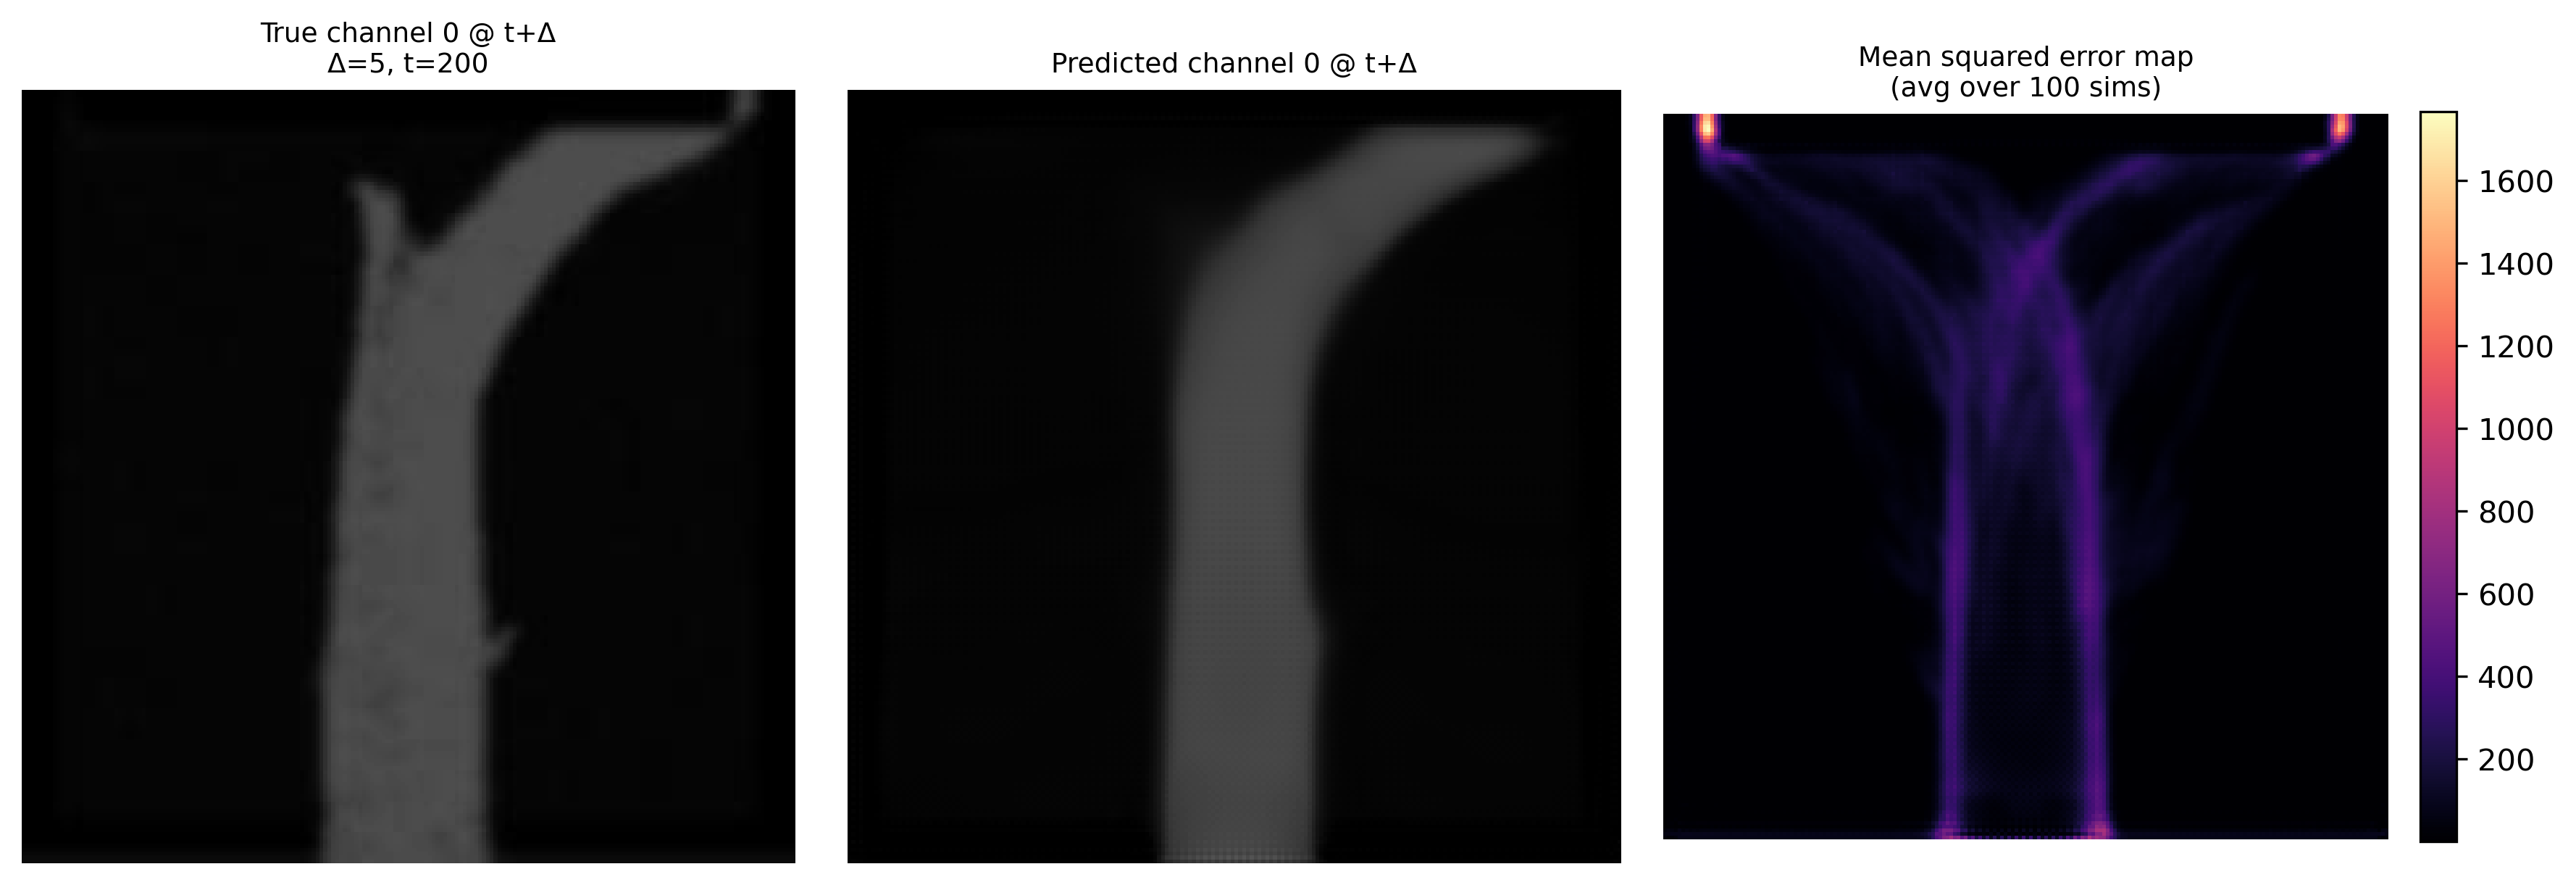

Heatmap for strip_d10_n16


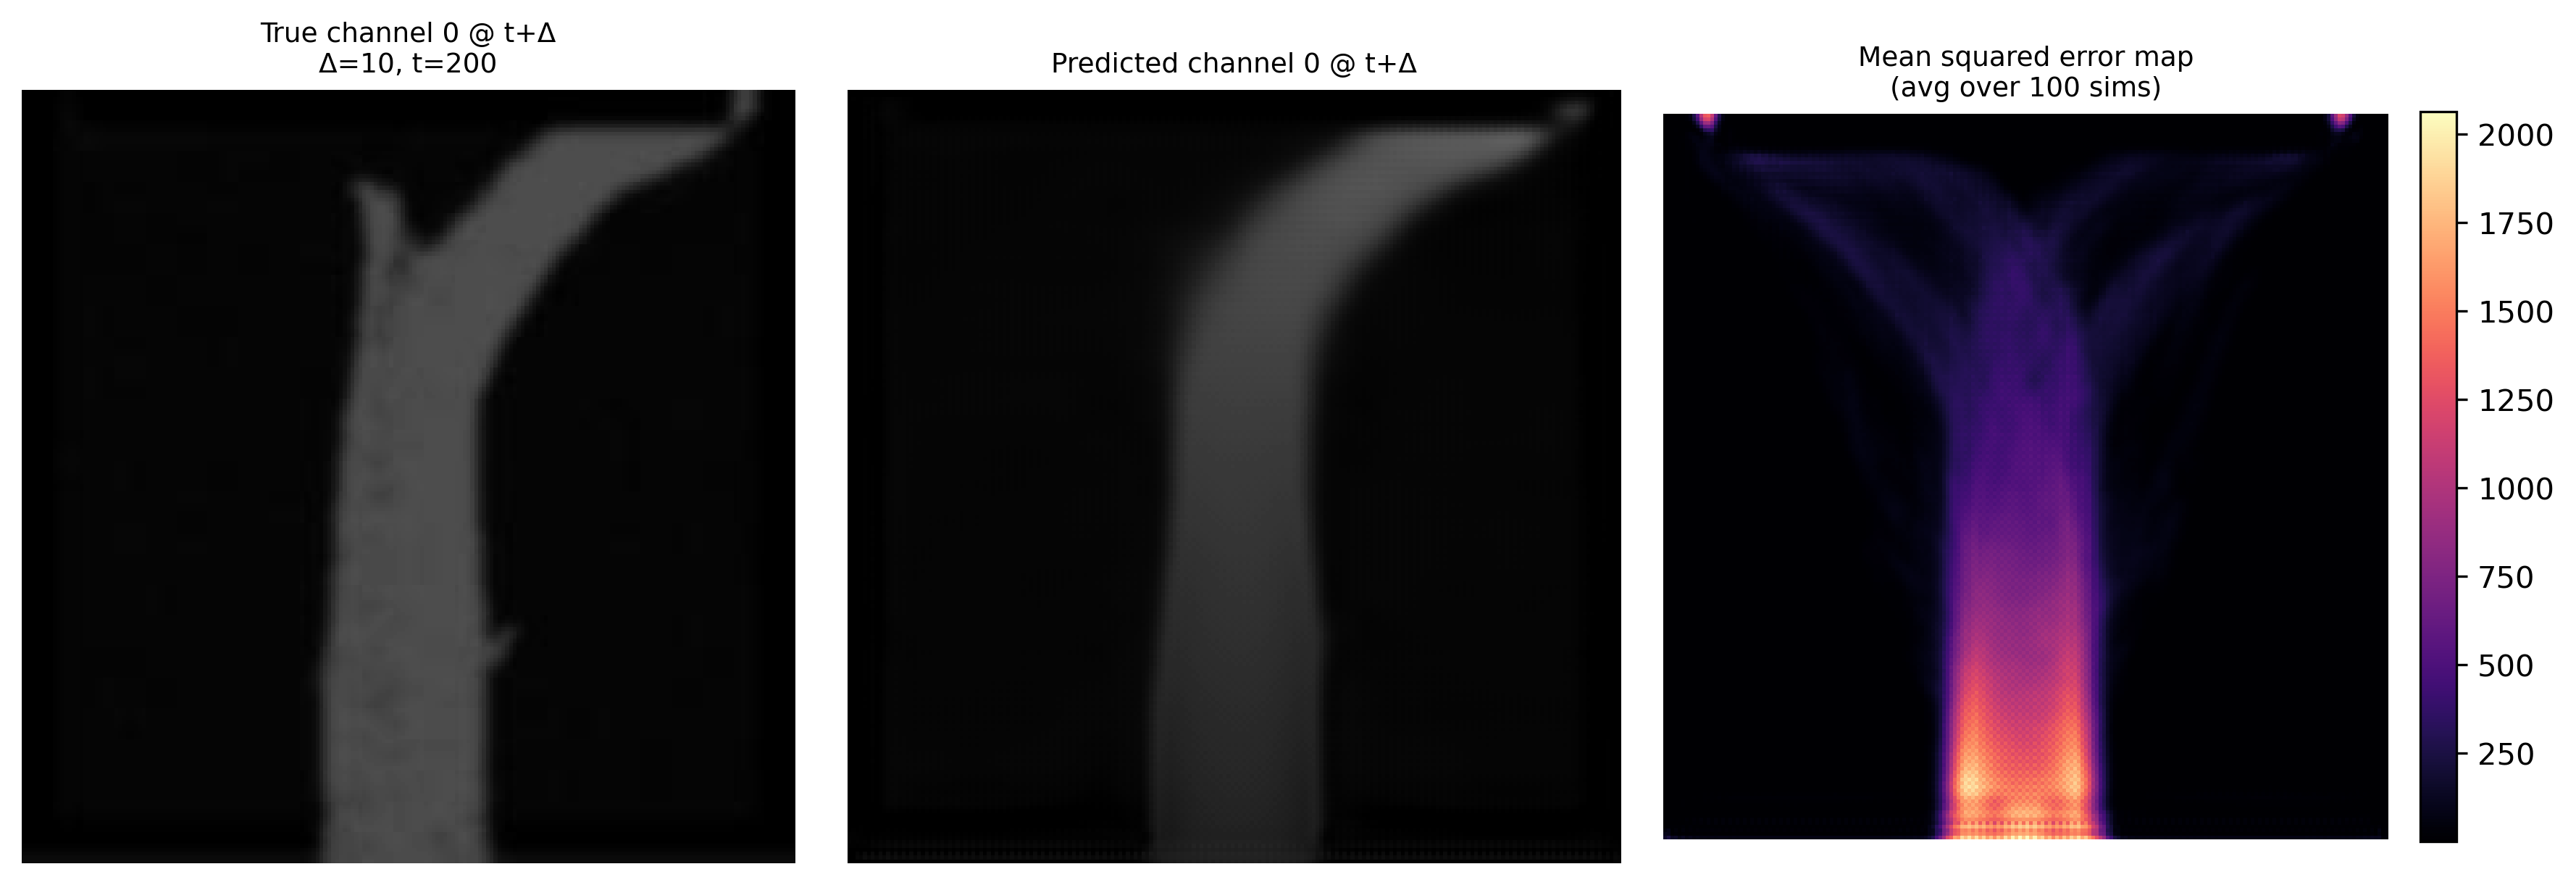

Heatmap for strip_d20_n16


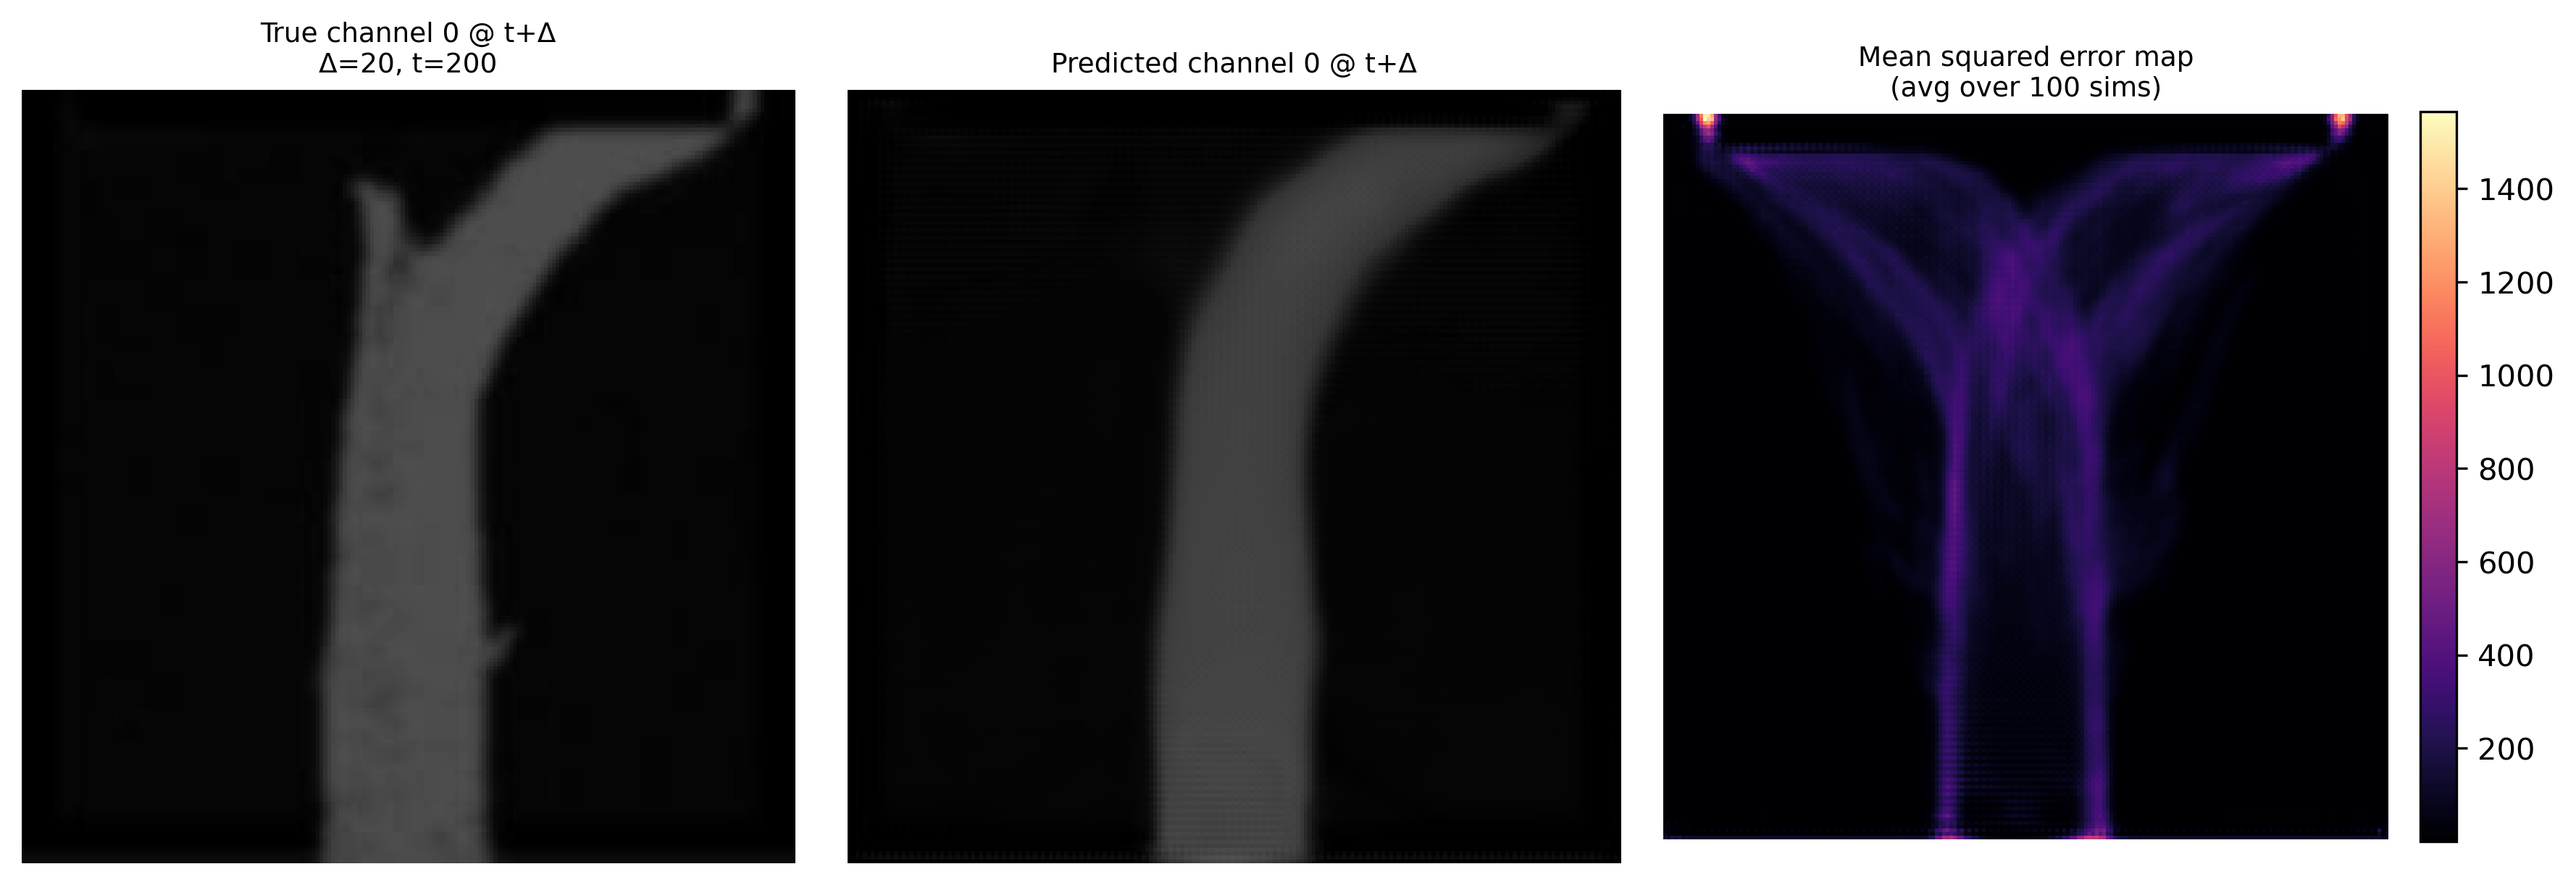

In [11]:
for test in tests:
    name = test["name"]
    print(f"Heatmap for {name}")

    meta         = np.load(f"{path}meta_{name}.npz", allow_pickle=True)
    future_delta = int(meta["future_delta"]) if "future_delta" in meta.files else test["future_delta"]

    model = torch.load(
        f"{path}{name}.pt",
        weights_only=False,
        map_location=torch.device("cpu"),
    ).to(device)

    # e.g. use first 100 validation sims, pressure channel, t=50
    show_heatmap_mse(
        model,
        meta,
        future_delta=future_delta,
        time_val=200,
        sims=None,        # or sims=list(range(100))
        channel=0,        # 1 = pressure
    )

In [12]:
import torch
import numpy as np

# SIM_STEPS = 201
# val_sims available globally
# make_sample_for_sim_time(sim_id, time_t, meta, future_delta) -> (z, t_label, t)

def compute_error_maps_over_time(
    model,
    meta,
    future_delta=0,
    channel=1,          # 0=K, 1=P, 2=phi
    sims=None,          # list of indices into val_sims; if None, use first N
    t_start=1,
    t_end=None,         # last *starting* time to consider
):

    model.eval()

    # pick which validation sims to average over
    if sims is None:
        N = min(100, len(val_sims))   # you can bump 100 up/down
        sims = list(range(N))         # indices into val_sims

    if t_end is None:
        # we can’t start later than SIM_STEPS-1-Δ, or t+Δ runs off the end
        t_end = SIM_STEPS - 1 - future_delta

    times = list(range(t_start, t_end + 1))  # inclusive

    # Use one example to infer shape
    example_sim_id = int(val_sims[sims[0]])
    z0, t_label0, t0 = make_sample_for_sim_time(example_sim_id, times[0], meta, future_delta)
    C, H, W = t_label0.shape

    # error_maps[t_idx, H, W]
    error_maps = np.zeros((len(times), H, W), dtype=np.float32)

    for ti, t in enumerate(times):
        # accumulate error for this time over all sims
        err_accum = torch.zeros(H, W, dtype=torch.float32, device=device)
        count = 0

        for idx in sims:
            sim_id = int(val_sims[idx])

            # build input / label for this sim and time
            z, t_label, t_actual = make_sample_for_sim_time(sim_id, t, meta, future_delta)
            # (if make_sample adjusts t, you could override with t_actual if needed)

            z       = z.to(device).unsqueeze(0)   # (1,C,H,W)
            t_label = t_label.to(device)

            with torch.no_grad():
                out = model(z)[0]                 # (C,H,W)

            diff = (out[channel] - t_label[channel]) ** 2  # (H,W)
            err_accum += diff
            count += 1

        mean_err = (err_accum / max(1, count)).cpu().numpy()
        error_maps[ti] = mean_err

    return times, error_maps

In [42]:
meta  = np.load("meta_strip_d20_n16.npz", allow_pickle=True)
model = torch.load("strip_d20_n16.pt", weights_only=False,
                   map_location=torch.device("cpu")).to(device)

times, error_maps = compute_error_maps_over_time(
    model,
    meta,
    future_delta=60,
    channel=0,       # pressure
    sims=None,       # first ~100 validation sims
    t_start=10,
    t_end=120,
)

In [15]:
import matplotlib.pyplot as plt
import imageio.v2 as imageio

def make_error_video(
    times,
    error_maps,
    out_path="error_video.gif",
    fps=5,
    cmap="magma",
    title_prefix="MSE heatmap",
    future_delta=0,
):
    """
    times: list of starting times t
    error_maps: np.array of shape (T, H, W)
    """
    T, H, W = error_maps.shape

    vmax = float(error_maps.max())
    vmin = 0.0

    frames = []

    for i, t in enumerate(times):
        err = error_maps[i]

        fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
        im = ax.imshow(err, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(f"{title_prefix}\n t={t}, Δ={future_delta}", fontsize=9)
        ax.axis("off")

        # draw to canvas and convert to image array
        fig.canvas.draw()
        buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        frame = buf.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        frame = frame[:, :, :3]  # drop alpha channel
        frames.append(frame)

        plt.close(fig)

    # save as gif or mp4 (gif is easiest, mp4 needs ffmpeg installed)
    imageio.mimsave(out_path, frames, fps=fps)
    print(f"Saved video to {out_path}")

In [44]:
# after computing times, error_maps above
make_error_video(
    times,
    error_maps,
    out_path="err_delta20_k.gif",
    fps=6,
    title_prefix="Pressure MSE",
    future_delta=20,
)

Saved video to err_delta20_k.gif


In [ ]:
vals = range(140)
f_delta_values = list(vals[::20])
print(f_delta_values)

tests = [
    {
        "name": f"full_d{d}_n16_clean",
        "reveal_strategy": "disks",
        "n_points": 16,
        "radius": 5,
        "mixed": False,
        "noise": 0, 
        "deterministic_mask": False,
        "jitter_std": 0.02,
        "reveal_dim": [[(0.2, .8)],[(.2,.8)]],
        "future_delta": d,
    }
    for d in f_delta_values
]

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138]


In [ ]:
for test in tests:
    name = test["name"]
    d    = int(test["future_delta"])

    print(f"Making error videos for {name} (Δ={d})")

    meta  = np.load(f"meta_{name}.npz", allow_pickle=True)
    model = torch.load(
        f"{name}.pt",
        weights_only=False,
        map_location=torch.device("cpu")
    ).to(device)

    # Use same SIM_STEPS convention as training
    # steps ∈ [1, SIM_STEPS-1-d] to keep t+Δ in-bounds
    t_start = 10
    t_end   = SIM_STEPS - 1 - d   # if SIM_STEPS = 201, this is 200-d

    # --- K channel (0) ---
    times, error_maps_k = compute_error_maps_over_time(
        model      = model,
        meta       = meta,
        future_delta = d,
        channel    = 0,         # 0 = K
        sims       = None,      # let function choose validation sims
        t_start    = t_start,
        t_end      = t_end,
    )

    make_error_video(
        times      = times,
        error_maps = error_maps_k,
        out_path   = f"err_delta{d}_k.gif",
        fps        = 6,
        title_prefix = f"K MSE",
        future_delta = d,
    )

    # --- P channel (1) ---
    _, error_maps_p = compute_error_maps_over_time(
        model      = model,
        meta       = meta,
        future_delta = d,
        channel    = 1,         # 1 = P
        sims       = None,
        t_start    = t_start,
        t_end      = t_end,
    )

    make_error_video(
        times      = times,     # same times
        error_maps = error_maps_p,
        out_path   = f"err_delta{d}_p.gif",
        fps        = 6,
        title_prefix = f"P MSE",
        future_delta = d,
    )

Making error videos for full_d0_n16_clean (Δ=0)
Saved video to err_delta0_k.gif
Saved video to err_delta0_p.gif
Making error videos for full_d2_n16_clean (Δ=2)
Saved video to err_delta2_k.gif
Saved video to err_delta2_p.gif
Making error videos for full_d4_n16_clean (Δ=4)
Saved video to err_delta4_k.gif
Saved video to err_delta4_p.gif
Making error videos for full_d6_n16_clean (Δ=6)
Saved video to err_delta6_k.gif
Saved video to err_delta6_p.gif
Making error videos for full_d8_n16_clean (Δ=8)
Saved video to err_delta8_k.gif
Saved video to err_delta8_p.gif
Making error videos for full_d10_n16_clean (Δ=10)
Saved video to err_delta10_k.gif
Saved video to err_delta10_p.gif
Making error videos for full_d12_n16_clean (Δ=12)
Saved video to err_delta12_k.gif
Saved video to err_delta12_p.gif
Making error videos for full_d14_n16_clean (Δ=14)
Saved video to err_delta14_k.gif
Saved video to err_delta14_p.gif
Making error videos for full_d16_n16_clean (Δ=16)
Saved video to err_delta16_k.gif
Saved vid

KeyboardInterrupt: 